# Impacto de la Educación Financiera en el Ahorro

El objetivo de este proyecto era saber cual es la probabilidad de que el conocimiento Financiero impacta en el ahorro de una persona, para ello se uso algunas técnicas de Machine Learning y una base de Datos obtenida de la Encuesta Nacional de Capacidades Financieras. La variable de Ahorro esta conformada por un apartado en la encuesta si es que los encuestados han ahorrado de alguna manera sea formal o informalmente.

In [1]:

import matplotlib.pyplot as plt
!pip install statsmodels


import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 55.6 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
df_ENCF = pd.read_csv('/work/ENCP 2019.csv')

In [3]:
df_ENCF.head()

,ENC,D01,PA,D02,D051,D052,D053,D054,D055,D05_AD,...,NSEX,NIVEL3,DISTRITOX,HORA_FIN,CUOTA_GENERO,CUOTA_RANGO_EDAD,CUOTA_NIVEL,REGION,DISTRIBU,WTVAR
0,1685964,Mujer,Urbano,Ucayali,Con otros familiares adultos,NaN,NaN,NaN,NaN,5,...,E,E,Yarinacocha,01 Jan 00,Femenino,40 A 70,E,Oriente,Oriente - Urbano,1.004183
1,1685984,Hombre,Urbano,Piura,Con otros familiares adultos,NaN,NaN,NaN,NaN,4,...,C,C1,Sechura,01 Jan 00,Masculino,40 A 70,C,Costa Norte,Costa Norte - Urbano,1.002867
2,1686044,Mujer,Urbano,Ucayali,Con al menos un niño menor de 18 años,Con otros familiares adultos,NaN,NaN,NaN,3,...,C,C2,Calleria,01 Jan 00,Femenino,18 A 24,C,Oriente,Oriente - Urbano,0.998123
3,1686048,Hombre,Urbano,Piura,Con un compañero(a)/esposo(a),NaN,NaN,NaN,NaN,4,...,D,D,Sechura,01 Jan 00,Masculino,40 A 70,D,Costa Norte,Costa Norte - Urbano,1.002867
4,1686097,Mujer,Urbano,Piura,Con otros familiares adultos,NaN,NaN,NaN,NaN,2,...,C,C2,Sechura,01 Jan 00,Femenino,25 A 39,C,Costa Norte,Costa Norte - Urbano,1.008714


## El Ahorro

In [4]:
df_ENCF['F03B_1_Rp'] = df_ENCF['F03B_1_Rp'].replace(['Sí','No' , 'No responde'  ] , [1,0,0])
df_ENCF['F03B_2_Rp'] = df_ENCF['F03B_2_Rp'].replace(['Sí','No' , 'No responde'  ] , [1,0,0])
df_ENCF['F03B_4_Rp'] = df_ENCF['F03B_4_Rp'].replace(['Sí','No' , 'Cuenta de ahorro'  ] , [1,0,0])
df_ENCF['F03B_5_Rp'] = df_ENCF['F03B_5_Rp'].replace(['Sí','No' , 'No sabe', 'Cuenta corriente'  ] , [1,0,0,0])
df_ENCF['F03B_9_Rp'] = df_ENCF['F03B_9_Rp'].replace(['Sí','No' , 'No responde', 'No sabe', 'Préstamo personal'  ] , [1,0,0,0,0])

In [5]:
df_ENCF['F03B_1_Rp'] = df_ENCF['F03B_1_Rp'].fillna(0)
df_ENCF['F03B_2_Rp'] = df_ENCF['F03B_2_Rp'].fillna(0)
df_ENCF['F03B_4_Rp'] = df_ENCF['F03B_4_Rp'].fillna(0)
df_ENCF['F03B_5_Rp'] = df_ENCF['F03B_5_Rp'].fillna(0)
df_ENCF['F03B_9_Rp'] = df_ENCF['F03B_9_Rp'].fillna(0)


In [6]:
df_ENCF['Ahorro'] = df_ENCF['F03B_1_Rp'] + df_ENCF['F03B_2_Rp'] + df_ENCF['F03B_4_Rp'] + df_ENCF['F03B_5_Rp'] + df_ENCF['F03B_9_Rp']
df_ENCF.loc[df_ENCF['Ahorro'] == 0 , 'Ahorro'] = 0 
df_ENCF.loc[df_ENCF['Ahorro'] != 0 , 'Ahorro'] = 1
df_ENCF['Ahorro'].value_counts()

0.0    667
1.0    540
Name: Ahorro, dtype: int64

## Indice de Conocimiento Financiero

In [7]:
df_ENCF.loc[df_ENCF['K02'] == 200, 'Preg1'] = 1 
df_ENCF.loc[df_ENCF['K02'] != 200, 'Preg1'] = 0
df_ENCF.loc[df_ENCF['K03'] == 'Menos de lo que ellos pueden comprar hoy', 'Preg2'] = 1 
df_ENCF.loc[df_ENCF['K03'] != 'Menos de lo que ellos pueden comprar hoy', 'Preg2'] = 0
df_ENCF.loc[df_ENCF['K04'] == 'No se paga interés / no /  nada', 'Preg3'] = 1 
df_ENCF.loc[df_ENCF['K04'] != 'No se paga interés / no /  nada' ,'Preg3'] = 0
df_ENCF.loc[df_ENCF['K05'] == 102.0 , 'Preg4'] = 1 
df_ENCF.loc[df_ENCF['K05'] != 102.0 , 'Preg4'] = 0
df_ENCF.loc[df_ENCF['K06'] == 'Más de 110 soles' , 'Preg5'] = 1 
df_ENCF.loc[df_ENCF['K06'] != 'Más de 110 soles' , 'Preg5'] = 0
df_ENCF.loc[df_ENCF['K07_1_Rp'] == 'Verdadero' , 'Preg6'] = 1 
df_ENCF.loc[df_ENCF['K07_1_Rp'] != 'Verdadero' , 'Preg6'] = 0
df_ENCF.loc[df_ENCF['K07_2_Rp'] == 'Verdadero' , 'Preg7'] = 1 
df_ENCF.loc[df_ENCF['K07_2_Rp'] != 'Verdadero' , 'Preg7'] = 0
df_ENCF.loc[df_ENCF['K07_3_Rp'] == 'Verdadero' , 'Preg8'] = 1 
df_ENCF.loc[df_ENCF['K07_3_Rp'] != 'Verdadero' , 'Preg8'] = 0

In [8]:
df_ENCF['sum1'] =df_ENCF['Preg1'] +df_ENCF['Preg2'] +df_ENCF['Preg3'] +df_ENCF['Preg4'] +df_ENCF['Preg5'] +df_ENCF['Preg6'] +df_ENCF['Preg7'] +df_ENCF['Preg8']
df_ENCF['ICF'] =df_ENCF['sum1']/0.8
df_ENCF['ICF'].max()

10.0

## Variables de Control

In [9]:
df_ENCF['N1'].value_counts()

Secundaria completa/ Superior Técnico Incompleta    485
Primaria Incomp./ Comp./ Secundaria Incompleta      242
Superior Técnico Completa                           219
Superior Univ. Completa                             174
Superior Univ. Incompleta                            51
Post-Grado Universitario                             22
Sin educación/ Educación Inicial                     11
Name: N1, dtype: int64

In [10]:
df_ENCF.loc[df_ENCF['N1'] == 'Sin educación/ Educación Inicial' , 'nivel_educacion_1'] = 1
df_ENCF.loc[df_ENCF['N1'] != 'Sin educación/ Educación Inicial' , 'nivel_educacion_1'] = 0
df_ENCF.loc[df_ENCF['N1'] == 'Primaria Incomp./ Comp./ Secundaria Incompleta' , 'nivel_educacion_2'] = 1
df_ENCF.loc[df_ENCF['N1'] != 'Primaria Incomp./ Comp./ Secundaria Incompleta' , 'nivel_educacion_2'] = 0
df_ENCF.loc[df_ENCF['N1'] == 'Secundaria completa/ Superior Técnico Incompleta' , 'nivel_educacion_3'] = 1
df_ENCF.loc[df_ENCF['N1'] != 'Secundaria completa/ Superior Técnico Incompleta' , 'nivel_educacion_3'] = 0
df_ENCF.loc[df_ENCF['N1'] == 'Superior Técnico Completa' , 'nivel_educacion_4'] = 1
df_ENCF.loc[df_ENCF['N1'] != 'Superior Técnico Completa' , 'nivel_educacion_4'] = 0
df_ENCF.loc[df_ENCF['N1'] == 'Superior Univ. Incompleta' , 'nivel_educacion_5'] = 1
df_ENCF.loc[df_ENCF['N1'] != 'Superior Univ. Incompleta' , 'nivel_educacion_5'] = 0
df_ENCF.loc[df_ENCF['N1'] == 'Superior Univ. Completa' , 'nivel_educacion_6'] = 1
df_ENCF.loc[df_ENCF['N1'] != 'Superior Univ. Completa' , 'nivel_educacion_6'] = 0
df_ENCF.loc[df_ENCF['N1'] == 'Post-Grado Universitario' , 'nivel_educacion_7'] = 1 
df_ENCF.loc[df_ENCF['N1'] != 'Post-Grado Universitario' , 'nivel_educacion_7'] = 0 

In [11]:
df_ENCF.loc[df_ENCF['D01'] == 'Hombre' , 'Sexo'] = 1
df_ENCF.loc[df_ENCF['D01'] != 'Hombre' , 'Sexo'] = 0
df_ENCF.loc[df_ENCF['PA'] == 'Urbano' , 'Urbano'] = 1
df_ENCF.loc[df_ENCF['PA'] != 'Urbano' , 'Urbano'] = 0
df_ENCF.loc[df_ENCF['D051'] == 'Con al menos un niño menor de 18 años' , 'Hijos'] = 1
df_ENCF.loc[df_ENCF['D051'] != 'Con al menos un niño menor de 18 años' , 'Hijos'] = 0
df_ENCF.loc[df_ENCF['D051'] == 'Con un compañero(a)/esposo(a)' , 'Convivencia'] = 1
df_ENCF.loc[df_ENCF['D051'] != 'Con un compañero(a)/esposo(a)' , 'Convivencia'] = 0
df_ENCF.loc[df_ENCF['D13'] ==  'Sí es' , 'Ingreso'] = 1
df_ENCF.loc[df_ENCF['D13'] !=  'Sí es' , 'Ingreso'] = 0


## Sampling Training

In [12]:
df_work = pd.DataFrame()
df_work['Ahorro'] = df_ENCF['Ahorro']
df_work['ICF'] = df_ENCF['ICF']
df_work['Sexo'] = df_ENCF['Sexo']
df_work['Convivencia'] = df_ENCF['Convivencia']
df_work['Urbano'] = df_ENCF['Urbano']
df_work['Hijos'] = df_ENCF['Hijos']
df_work['Ingreso_Regular'] = df_ENCF['Ingreso']
df_work['Edad'] =df_ENCF['D07']
df_work['Edad2'] = df_work['Edad'] * df_work['Edad']
df_work['Educacion_Inicial'] = df_ENCF['nivel_educacion_1']
df_work['Educacion_Primaria'] = df_ENCF['nivel_educacion_2']
df_work['Educacion_Secundaria'] = df_ENCF['nivel_educacion_3']
df_work['Educacion_Tecnica'] = df_ENCF['nivel_educacion_4']
df_work['Educacion_UnivInc'] = df_ENCF['nivel_educacion_5']
df_work['Educacion_UnivCom'] = df_ENCF['nivel_educacion_6']
df_work['Educacion_Postgrado'] = df_ENCF['nivel_educacion_7']

In [13]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ahorro                1207 non-null   float64
 1   ICF                   1207 non-null   float64
 2   Sexo                  1207 non-null   float64
 3   Convivencia           1207 non-null   float64
 4   Urbano                1207 non-null   float64
 5   Hijos                 1207 non-null   float64
 6   Ingreso_Regular       1207 non-null   float64
 7   Edad                  1204 non-null   float64
 8   Edad2                 1204 non-null   float64
 9   Educacion_Inicial     1207 non-null   float64
 10  Educacion_Primaria    1207 non-null   float64
 11  Educacion_Secundaria  1207 non-null   float64
 12  Educacion_Tecnica     1207 non-null   float64
 13  Educacion_UnivInc     1207 non-null   float64
 14  Educacion_UnivCom     1207 non-null   float64
 15  Educacion_Postgrado  

In [14]:
df_work.isnull().sum()

Ahorro                  0
ICF                     0
Sexo                    0
Convivencia             0
Urbano                  0
Hijos                   0
Ingreso_Regular         0
Edad                    3
Edad2                   3
Educacion_Inicial       0
Educacion_Primaria      0
Educacion_Secundaria    0
Educacion_Tecnica       0
Educacion_UnivInc       0
Educacion_UnivCom       0
Educacion_Postgrado     0
dtype: int64

In [15]:
df_work.dropna(inplace= True)

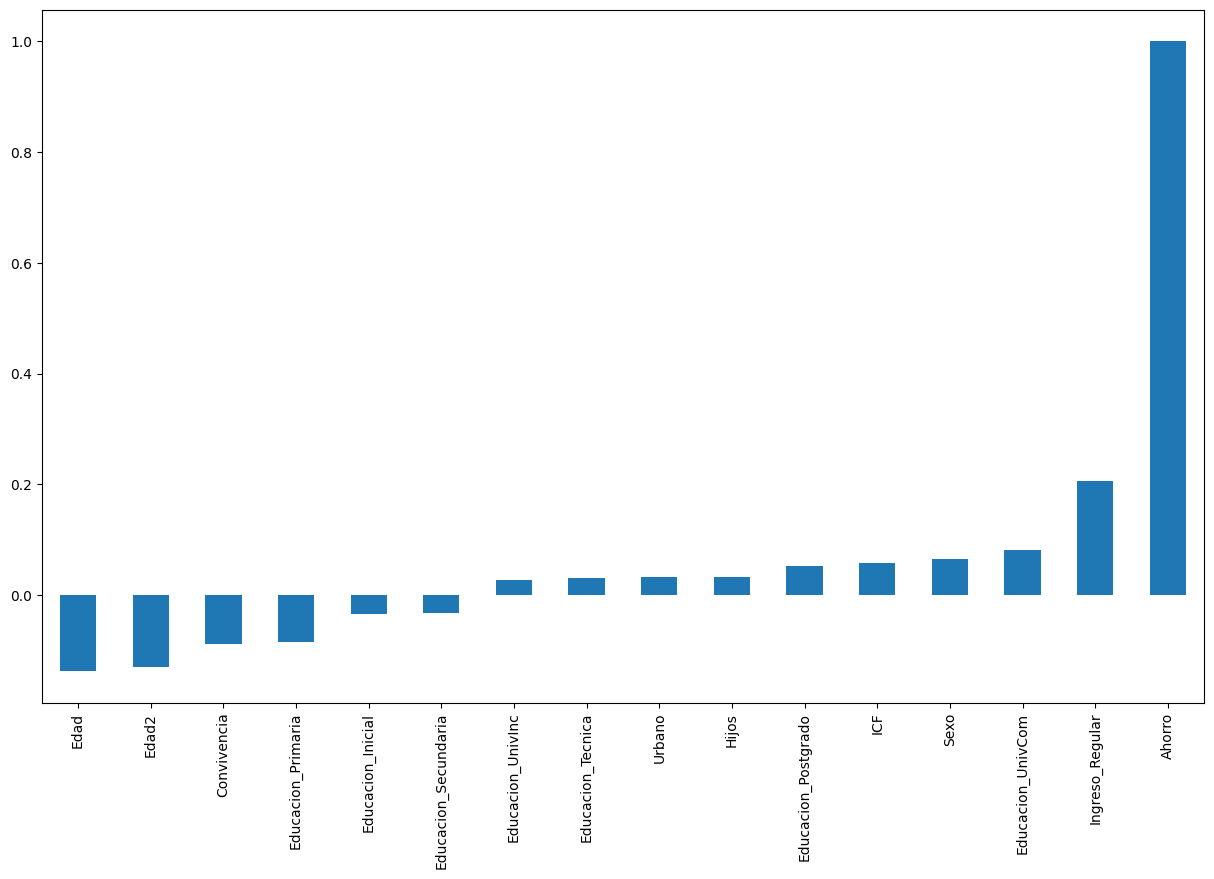

In [16]:
fig = plt.figure(figsize=(15,9))
df_work.corr()['Ahorro'].sort_values(ascending=True).plot(kind='bar')
plt.show()

In [17]:
X = df_work.drop('Ahorro', axis =1)
y = df_work['Ahorro'].values

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state= 42)

In [19]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)
from sklearn import metrics
prediction_test = model.predict(X_test)
print(metrics.accuracy_score(y_test,prediction_test ))

0.6212624584717608


In [20]:
import statsmodels.api as smf
probit_model=smf.Probit(y,X)
result=probit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.649155
         Iterations 5
                          Results: Probit
Model:                Probit           Pseudo R-squared: 0.056     
Dependent Variable:   y                AIC:              1593.1643 
Date:                 2023-02-03 23:17 BIC:              1669.5654 
No. Observations:     1204             Log-Likelihood:   -781.58   
Df Model:             14               LL-Null:          -827.73   
Df Residuals:         1189             LLR p-value:      1.3928e-13
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       5.0000                                       
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------
ICF                   0.0023   0.0209  0.1098 0.9126 -0.0386 0.0432
Sexo                  0.1458   0.0771  1

## Sampling Training II

In [21]:
df_work2 = pd.DataFrame()
df_work2['Ahorro'] = df_ENCF['Ahorro']
df_work2['ICF'] = df_ENCF['ICF']
df_work2['Sexo'] = df_ENCF['Sexo']
df_work2['Convivencia'] = df_ENCF['Convivencia']
df_work2['Urbano'] = df_ENCF['Urbano']
df_work2['Hijos'] = df_ENCF['Hijos']
df_work2['Ingreso_Regular'] = df_ENCF['Ingreso']
df_work2['Edad'] =df_ENCF['D07']
df_work2['Edad2'] = df_work['Edad'] * df_work['Edad']

In [33]:
df_work2.isnull().sum()

Ahorro             0
ICF                0
Sexo               0
Convivencia        0
Urbano             0
Hijos              0
Ingreso_Regular    0
Edad               0
Edad2              0
dtype: int64

In [32]:
df_work2.dropna(inplace= True)

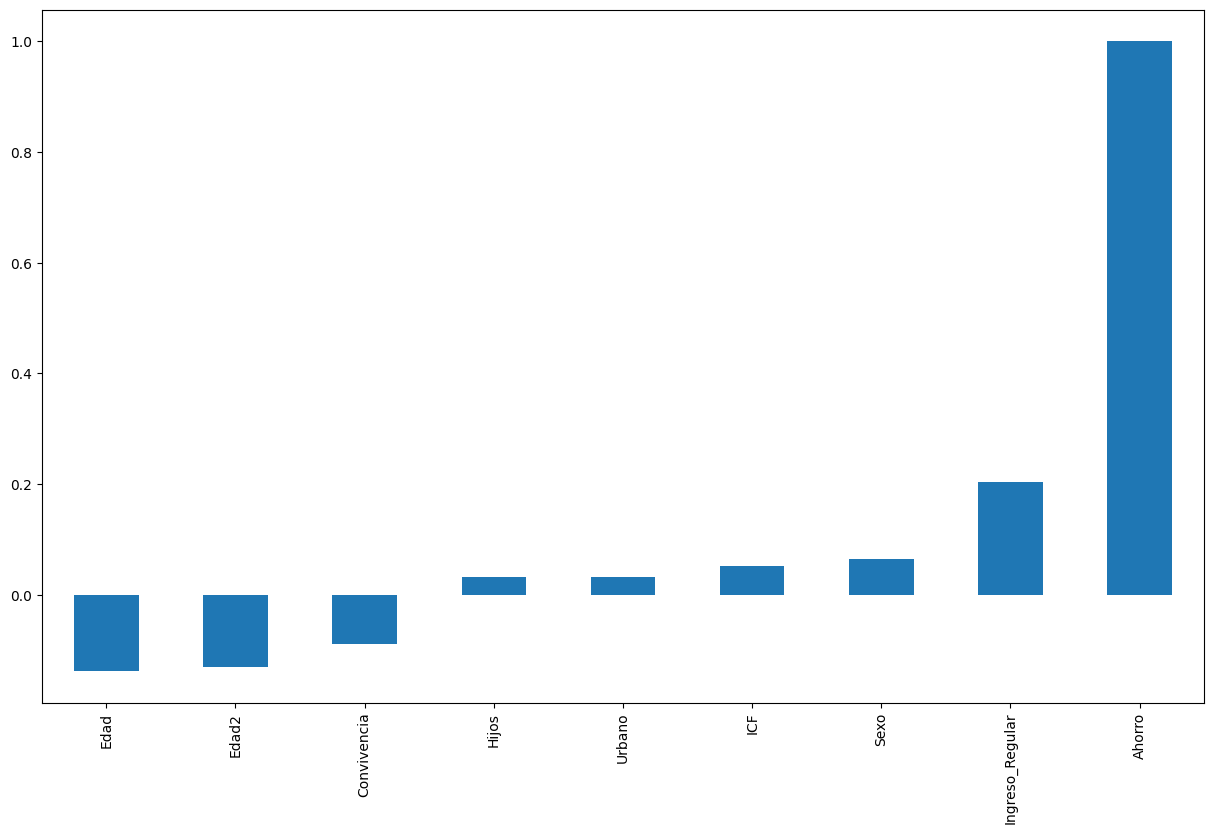

In [30]:
fig = plt.figure(figsize=(15,9))
df_work2.corr()['Ahorro'].sort_values(ascending=True).plot(kind='bar')
plt.show()

In [34]:
X = df_work2.drop('Ahorro', axis =1)
y = df_work2['Ahorro'].values

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state= 42)

In [36]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)
from sklearn import metrics
prediction_test = model.predict(X_test)
print(metrics.accuracy_score(y_test,prediction_test ))

0.5863787375415282


In [37]:
import statsmodels.api as smf
probit_model=smf.Probit(y,X)
result=probit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.653285
         Iterations 5
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.050     
Dependent Variable: y                AIC:              1589.1095 
Date:               2023-02-03 23:28 BIC:              1629.8567 
No. Observations:   1204             Log-Likelihood:   -786.55   
Df Model:           7                LL-Null:          -827.73   
Df Residuals:       1196             LLR p-value:      4.5538e-15
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
ICF                0.0166   0.0197  0.8450 0.3981 -0.0220  0.0552
Sexo               0.1425   0.0760  1.8740 0.0609 -0.0065  0.2915

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85433a81-e282-4d7c-a3a7-0be0615342a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>